# CS 429: Information Retrieval
<br>

## Lecture 23: Clustering Words

<br>

### Dr. Aron Culotta
### Illinois Institute of Technology
### Spring 2015

# Motivation

Often, we want to know which features appear together.

- If you liked *Twilight* you might like *Nosferatu*.
- "happy" is a synonym of "glad."

We'll use k-means to cluster together related words from Twitter.

**Caution:** This uses live Twitter data, which often contains profanity.

In [30]:
# Get some tweets containing the word 'i'.

import os
from TwitterAPI import TwitterAPI

# Read Twitter credentials from environmental variables.
api = TwitterAPI(os.environ.get('TW_CONSUMER_KEY'),
                 os.environ.get('TW_CONSUMER_SECRET'),
                 os.environ.get('TW_ACCESS_TOKEN'),
                 os.environ.get('TW_ACCESS_TOKEN_SECRET'))

# Collect tweets until we hit rate limit.
tweets = []
while True: 
    r = api.request('search/tweets', {'q':'i',
                                      'language':'en',
                                      'count':'100'})
    if r.status_code != 200: # error
        break
    else:
        for item in r.get_iterator():
            tweets.append(item)


/Users/awculott/.local/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:79: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/Users/awculott/.local/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:79: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/Users/awculott/.local/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:79: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring S

In [93]:
print len(tweets)

18000


In [94]:
# Each tweet is a Python dict.
print 'text', tweets[0]['text']
print 'description:', tweets[0]['user']['description']
print 'name:', tweets[0]['user']['name']
print 'location:', tweets[0]['user']['location']

text @Factsionary @ThislsAmazing now I know the answer @poifakcha
description: Folle
name: Chxco
location: London ⚡️


In [95]:
# Tokenize each tweet text.
import re
tokens = []
for tweet in tweets:
    text = tweet['text'].lower()
    text = re.sub('@\S+', ' ', text)  # Remove mentions.
    text = re.sub('http\S+', ' ', text)  # Remove urls.
    tokens.append(re.findall('[A-Za-z]+', text)) # Retain words.
print tokens[0]

[u'now', u'i', u'know', u'the', u'answer']


In [96]:
# Count words.
from collections import Counter

word_counts = Counter()
for tweet in tokens:
    word_counts.update(tweet)

In [97]:
# Inspect word counts.
import math

print len(word_counts), 'unique terms'
sorted_counts = sorted(word_counts.items(),
                       key=lambda x: x[1],
                       reverse=True)
print '\n'.join('%s\t%d' % (w, c) for w, c in sorted_counts[:10])

19825 unique terms
i	21847
rt	6369
to	5200
you	4943
the	4752
a	4563
m	3245
my	3137
and	3135
it	2793


In [98]:
# Retain in vocabulary words occurring more than twice.
vocab = set([w for w, c in word_counts.iteritems() if c > 1])
print '%d words occur at least two times.' % len(vocab)

8110 words occur at least two times.


In [99]:
# Prune tokens.
newtoks = []
for i, tweet in enumerate(tokens):
    newtok = [token for token in tweet if token in vocab]
    if len(newtok) > 0:
        newtoks.append(newtok)
tokens = newtoks

In [100]:
# A sample pruned tweet.
print tokens[0]

[u'now', u'i', u'know', u'the', u'answer']


In [101]:
# For each term, create a context vector, indicating how often
# each word occurs to the left or right of it.
from collections import defaultdict
import numpy as np

# dict from term to context vector.
contexts = defaultdict(lambda: Counter())
window = 2
for tweet in tokens:
    for i, token in enumerate(tweet):
        features = []
        for j in range(np.amax([0, i-window]), i):
            features.append(tweet[j] + "@" + str(j-i))
        for j in range(i+1, min(i + window, len(tweet))):
            features.append(tweet[j] + "@" + str(j-i))
        contexts[token].update(features)
        # Optionally: ignore word order
        # contexts[token].update(tweet[:i] + tweet[i+1:])


In [106]:
print contexts['i'].most_common(20)

[(u'm@1', 3109), (u'rt@-1', 2711), (u'love@1', 1161), (u'can@1', 741), (u'and@-1', 693), (u'don@1', 693), (u've@1', 677), (u'rt@-2', 613), (u'll@1', 563), (u'have@1', 559), (u'just@1', 535), (u'but@-1', 513), (u'want@1', 513), (u'when@-1', 508), (u'i@-2', 479), (u'need@1', 463), (u'am@1', 462), (u'was@1', 452), (u'the@-2', 404), (u'think@1', 386)]


In [107]:
# Compute the number of different contexts each term appears in.
tweet_freq = Counter()
for context in contexts.itervalues():
    for term in context:
        tweet_freq[term] += 1.
print tweet_freq.most_common(5)

[(u'i@1', 2270.0), (u'i@-2', 2229.0), (u'the@-1', 1410.0), (u'a@-1', 1293.0), (u'and@1', 1260.0)]


In [108]:
# Transform each context vector to be term freq / tweet frequency. 
# Also then normalize by length.
for term, context in contexts.iteritems():
    for term2, frequency in context.iteritems():
        context[term2] = frequency / (1. + math.log(tweet_freq[term2]))
    length = math.sqrt(sum([v*v for v in context.itervalues()]))
    for term2, frequency in context.iteritems():
        context[term2] = 1. * frequency / length
    
print contexts['i'].most_common(5)

[(u'm@1', 0.6640846488053579), (u'rt@-1', 0.3978314887896183), (u'love@1', 0.22620270121884525), (u've@1', 0.1929220928503491), (u'll@1', 0.17616075975844525)]


In [111]:
print contexts['school'].most_common(10)

[(u'high@-1', 0.3827390635042453), (u'at@-1', 0.33172671494119954), (u'in@-1', 0.24121682682521658), (u'after@-1', 0.2376147346200189), (u'to@-1', 0.2374777714540307), (u'educated@-2', 0.20552307238268863), (u'hate@-1', 0.1964646178401917), (u'i@-2', 0.16518665450893733), (u'tomorrow@1', 0.15663390202669888), (u'i@1', 0.15306726969038806)]


At this point we have ~8k dictionaries, one per term, indicating the terms that co-occur (weighted by inverse tweet frequency).

Next, we have to cluster these vectors. To do this, we'll need to be able to compute the euclidean distance between two vectors.

In [65]:
# This is not efficient!
def distance(c1, c2):
    if len(c1.keys()) == 0 or len(c2.keys()) == 0:
        return 1e9
    keys = set(c1.keys()) | set(c2.keys())
    distance = 0.
    for k in keys:
        distance += (c1[k] - c2[k]) ** 2
    return math.sqrt(distance)

print distance({'hi':10, 'bye': 5}, {'hi': 9, 'bye': 4})
print distance({'hi':10, 'bye': 5}, {'hi': 8, 'bye': 4})

1.41421356237
2.2360679775


In [113]:
def find_closest(term, n=5):
    terms = np.array(contexts.keys())
    context = contexts[term]
    distances = []
    for term2, context2 in contexts.iteritems():
        distances.append(distance(context, context2))
    return terms[np.argsort(distances)][:n]

print find_closest('school', n=10)

[u'school' u'work' u'class' u'least' u'the' u'bed' u'prison' u'this'
 u'sleep' u'my']


In [114]:
nz_contexts = [t for t, context in contexts.items()
               if len(context) > 1]
contexts = dict([(term, contexts[term]) for term in nz_contexts])
print len(nz_contexts), 'nonzero contexts'

8085 nonzero contexts


In [115]:
# Transform context dicts to a sparse vector
# for sklearn.
from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer()
X = vec.fit_transform(contexts.values())
names = np.array(vec.get_feature_names())
print names[:10]
print X[0]

[u'a@-1' u'a@-2' u'a@1' u'aa@-1' u'aa@-2' u'aa@1' u'aaron@-1' u'aaron@-2'
 u'aaron@1' u'aaronsnewvideo@-1']
  (0, 17629)	0.368221454988
  (0, 10512)	0.557406688821
  (0, 9382)	0.236999665516
  (0, 3005)	0.20034364668
  (0, 20720)	0.2547897772
  (0, 19724)	0.516063348382
  (0, 22766)	0.35519729027


In [116]:
print names[17629]

s@-1


In [117]:
# Let's cluster!
from sklearn.cluster import KMeans
num_clusters = 20
kmeans = KMeans(num_clusters)
kmeans.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=20, n_init=10,
    n_jobs=1, precompute_distances=True, random_state=None, tol=0.0001,
    verbose=0)

In [118]:
# Let's print out the top features for each mean vector.
# This is swamped by common terms
for i in range(num_clusters):
    print i, ' '.join(names[np.argsort(kmeans.cluster_centers_[i])[::-1][:5]])

0 a@-1 i@1 a@-2 the@-1 and@1
1 the@-1 i@1 in@-2 to@-2 of@-2
2 to@-1 i@-2 i@-1 t@-1 my@1
3 my@-1 i@1 and@1 your@-1 on@-2
4 on@-1 i@1 the@-1 and@1 for@-1
5 i@1 i@-2 a@-2 the@-2 i@-1
6 in@1 i@-2 i@-1 the@-2 and@1
7 to@1 i@-2 i@-1 the@-1 i@1
8 i@1 i@-2 a@-2 rt@-1 the@-2
9 i@-2 m@-1 m@-2 be@-1 i@1
10 the@1 i@-2 a@1 my@1 to@-2
11 me@1 you@1 i@-2 i@-1 be@-1
12 in@-1 i@1 the@-1 to@-1 and@1
13 i@-2 love@-1 i@-1 i@1 ve@-1
14 some@-1 and@1 the@-1 for@-2 have@-2
15 of@1 the@-1 a@-1 a@-2 i@-2
16 m@-2 of@-1 at@-1 i@1 for@1
17 and@1 i@1 to@-2 so@-1 the@-1
18 i@-1 i@-2 rt@-2 a@1 just@-1
19 rt@-1 i@1 s@1 i@-2 el@1


In [119]:
# .transform will compute the distance from each context to each cluster.
distances = kmeans.transform(X)
print distances[0]

[ 1.05571538  1.07003861  1.06785113  1.07500105  1.05421705  0.99564929
  1.03059659  1.0700786   1.04912913  1.11096103  1.04385858  1.04656612
  1.03616752  1.04153675  1.05474465  1.07091558  1.01038773  1.02293292
  1.12312787  1.07523813]


In [120]:
# Finally, we'll print the words that are closest
# to the mean of each cluster.
terms = np.array(contexts.keys())
for i in range(num_clusters):
    print i, ' '.join(terms[np.argsort(distances[:,i])[1:10]]), '\n'

0 little good hobby cupcake job few xanax democrat parent 

1 pretenders truth most worst treadmill gym storyline divorce workplace 

2 get sleep hear say eat see marry win go 

3 dad own heart phone mom face brother hair fault 

4 nigganews thursday plum fire steroids craigslist shuffle twitter vimeo 

5 and time like everything lol way shit say all 

6 evenings atleticomadrid checked sluts interested smashed vert kicking uglier 

7 trying going used supposed listening refuse relate able wanted 

8 when yeah ofc and cause yes sext wow whenever 

9 dying not convinced starving hungry dead cassiopeia ticklish posing 

10 accepting earned on avoided all spreading at watch riding 

11 told makes send make sponsor pita call tells tell 

12 lexington helsinki public izmir hoodies september reality nigeria dudley 

13 humidity embarrassed appalled you seeing blessed reading never him 

14 food nights strips weird fries concerns evenings entertainment masculinity 

15 kind type part rest sort

Clearly, interpreting these results requires a bit of investigation.

Some patterns do emerge:
 - Cluster 7 has Polish
 - Cluster 8 are about communication acts
 - Cluster 13 is family
 - Cluster 14 seems to be abbreviations/[disfluencies](http://en.wikipedia.org/wiki/Speech_disfluency)

As the number of tweets increases, we expect these clusters to become more coherent.

**How does error decrease with number of cluster?**

In [121]:
print kmeans.score(X)

-7445.99342108


k=5 score=-7797.96
k=10 score=-7713.23
k=20 score=-7583.07
k=50 score=-7472.8
k=100 score=-7311.88


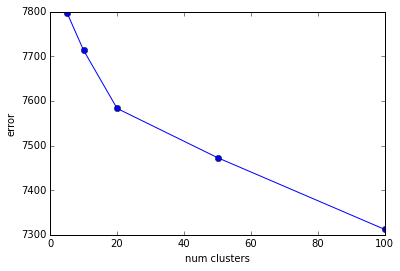

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

scores = []
num_cluster_options = [5,10,20,50,100]

for num_clusters in num_cluster_options:
    kmeans = KMeans(num_clusters, n_init=10, max_iter=10)
    kmeans.fit(X)
    score = -1 * kmeans.score(X)
    scores.append(score)
    print 'k=%d score=%g' % (num_clusters, score)
    
plt.figure()
plt.plot(num_cluster_options, scores, 'bo-')
plt.xlabel('num clusters')
plt.ylabel('error')
plt.show()

** How does error vary by initalization? **

score=7500.51
score=7487.98
score=7492.89
score=7476.02
score=7468.77
score=7493.28
score=7486.01
score=7519.28
score=7488.46
score=7525.88


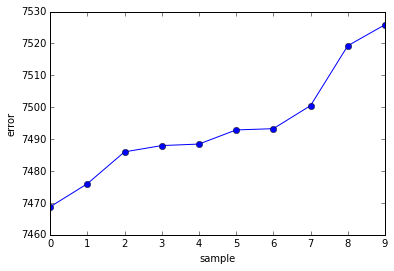

In [92]:
scores = []
for i in range(10):
    kmeans = KMeans(20, n_init=1, max_iter=100, init='random')
    kmeans.fit(X)
    score = -1 * kmeans.score(X)
    scores.append(score)
    print 'score=%g' % (score)
     
    
plt.figure()
plt.plot(range(10), sorted(scores), 'bo-')
plt.xlabel('sample')
plt.ylabel('error')
plt.show()